In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
%load_ext autoreload
%autoreload 2
# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from scipy.spatial import distance
from detectron2.evaluation import inference_on_dataset
from detectron2.evaluation import DatasetEvaluator


In [2]:
kp_file="/media/asad/adas_cv_2/test_kp.csv"
img_dir="/media/asad/ADAS_CV/datasets_Vegs/pepper/one_annotated/"

In [3]:
## load points dataset
#Third pepper
def load_points_dataset(f_p):
    with open(f_p,"r") as f:
        all_lines=f.readlines()
    points={}
    i=0
    while(i<len(all_lines)):
        if(i>len(all_lines)):
            break
        line=all_lines[i].split(",")
        label=line[0]
        file=line[3]
        first_point=None
        second_point=None
        if label=="head":
            first_point=(int(line[1]),int(line[2]))
        elif label =="tail":
            second_point=(int(line[1]),int(line[2]))
        i+=1
        if(i<len(all_lines)):
            line2=all_lines[i].split(",")
            if line2[3]==file:
                if line2[0]=="head":
                    first_point=(int(line2[1]),int(line2[2]))
                elif line2[0] =="tail":
                    second_point=(int(line2[1]),int(line2[2]))
                i+=1
        if file in points:
            # file already in dictionary append the list
            print(f"Appending the file to existing one {file}")
            points[file].append([first_point,second_point])
        else:
            points[file]=[[first_point,second_point]]
    return points

In [4]:
def get_imagePoints(imgPoints,nz_points):
    mindistances=[]
    for point in imgPoints:
        cpoint_head=None
        cpoint_tail=None
        # very high intitial distances
        dist_tail=12345
        dist_head=12345
        if point is not None and point[0] is not None:
            cpoint_head=min(nz_points,key=lambda c:distance.euclidean(c,point[0]))
            dist_head=distance.euclidean(cpoint_head,point[0])
        if point is not None and point[1] is not None:
            cpoint_tail=min(nz_points,key=lambda c:distance.euclidean(c,point[1]))
            dist_tail=distance.euclidean(cpoint_tail,point[1])
        mindistances.append(dist_tail+dist_head)
    index_min = min(range(len(mindistances)), key=mindistances.__getitem__)
    res=imgPoints[index_min]
    return res

In [5]:
gt_points=load_points_dataset(kp_file)

Appending the file to existing one 0010.jpg
Appending the file to existing one 0010.jpg
Appending the file to existing one 0010.jpg
Appending the file to existing one 0010.jpg


In [6]:
gt_points

{'0008.jpg': [[(1490, 947), (1320, 551)]],
 '0009.jpg': [[(559, 1205), (710, 632)]],
 '0011.jpg': [[(972, 520), (1369, 986)]],
 '0026.jpg': [[(821, 543), (1312, 884)]],
 '0038.jpg': [[(943, 859), (1274, 437)]],
 '0048.jpg': [[(802, 501), (1374, 697)]],
 '0010.jpg': [[(642, 1112), (625, 732)],
  [(2232, 896), (2766, 970)],
  [(3368, 436), (3305, 959)],
  [(4867, 709), (5049, 1237)],
  [(6190, 732), (5980, 1282)]]}

In [7]:
extensions=[".jpg",".JPEG",".jpg",".jpeg",".png"]
def get_cuc_dicts(img_dir):
    json_files = [json_file for json_file in os.listdir(img_dir) if json_file.endswith(".json")] 
    dataset_dicts = []
    for idx,json_file in enumerate(json_files):
        for ext in extensions:
            filename=json_file.split(".")[0]+ext
            c_fname=os.path.join(img_dir,filename)
            img=cv2.imread(c_fname)
            if img is not None:
                break
        if img is None:
            raise (f"Image Not Found for {json_file}")
        print(f"Processing json {json_file}")
        with open(os.path.join(img_dir,json_file)) as f:
            imgs_anns = json.load(f)
        record = {}      
        height, width = img.shape[:2] 
        record["file_name"] = c_fname
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        annos = imgs_anns["shapes"]
        objs = []
        for anno in annos:
            #assert not anno["region_attributes"]
            px = [x for x,y in anno]
            py = [y for x,y in anno]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            #print("Getting point annotations!!")
            keypoints=get_imagePoints(gt_points[filename],poly)
            ## fix poitns which are none
            if keypoints[0] is not None:
                x1,y1=keypoints[0]
                c1=2
            else:
                x1,y1=0.0,0.0
                c1=1
            if keypoints[0] is not None:
                x2,y2=keypoints[1]
                c2=2
            else:
                x2,y2=0.0,0.0
                c2=1
            poly = [p for x in poly for p in x]
            #print([x1,y1,c1,x2,y2,c2])
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "keypoints": [x1+0.5,y1+0.5,c1,x2+0.5,y2+0.5,c2],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        print(f"Processed images {idx}")
        dataset_dicts.append(record)
    return dataset_dicts

In [8]:
for d in ["train","valid"]:
        DatasetCatalog.register("pep_" + d, lambda d=d: get_cuc_dicts(img_dir + d))
        MetadataCatalog.get("pep_" + d).set(thing_classes=["pep"])
        MetadataCatalog.get("pep_" + d).set(keypoint_names=["head","tail"])
        MetadataCatalog.get("pep_" + d).set(keypoint_flip_map=[("head","head"),("tail","tail")])
        MetadataCatalog.get("pep_" + d).set(keypoint_connection_rules=[("head","tail",(0,255,255))])

In [9]:
pep_metadata = MetadataCatalog.get("pep_train")

In [10]:
pep_metadata

namespace(name='pep_train',
          thing_classes=['pep'],
          keypoint_names=['head', 'tail'],
          keypoint_flip_map=[('head', 'head'), ('tail', 'tail')],
          keypoint_connection_rules=[('head', 'tail', (0, 255, 255))])

In [11]:
dataset_dicts = DatasetCatalog.get("pep_train")

Processing json 0008.json
Processed images 0
Processing json 0009.json
Processed images 1
Processing json 0010.json
Processed images 2
Processing json 0011.json
Processed images 3
Processing json 0026.json
Processed images 4
Processing json 0038.json
Processed images 5
Processing json 0048.json
Processed images 6


In [12]:
len(dataset_dicts)

7

In [13]:
def draw_points(datalist,k=5):
    for i in range(k):
        data=datalist[i]
        #print(data)
        ann=data["annotations"]
        fn=data["file_name"]
        img=cv2.imread(fn)
        fig=plt.figure(figsize=(10,10))
        for d in ann:
            kp=d["keypoints"]
            #print(kp)
            x1,y1=int(kp[0]),int(kp[1])
            x2,y2=int(kp[3]),int(kp[4])
            cv2.circle(img,(x1,y1),14,(255,255,0),-1)
            cv2.circle(img,(x2,y2),14,(255,0,255),-1)
        plt.imshow(img[...,::-1])

In [14]:
#dataset_dicts

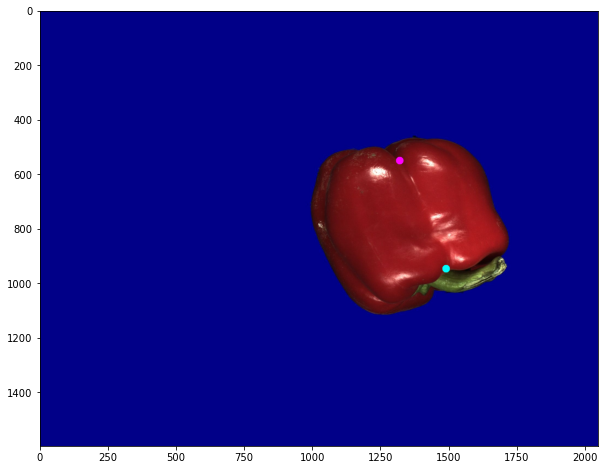

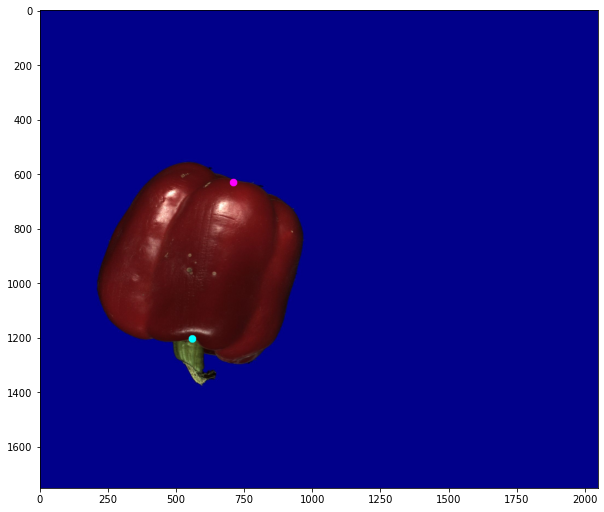

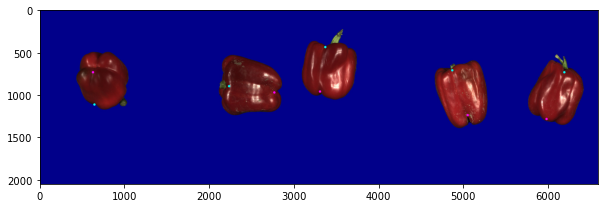

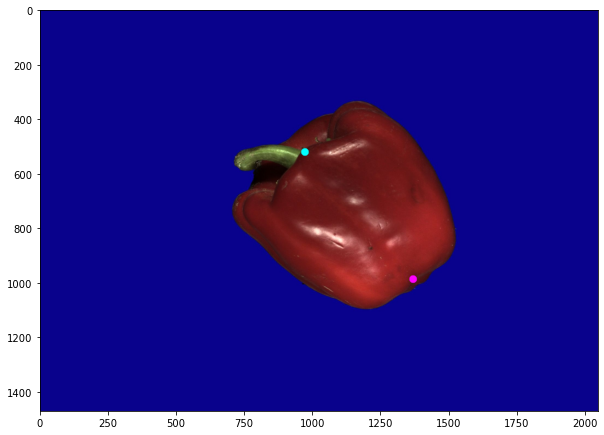

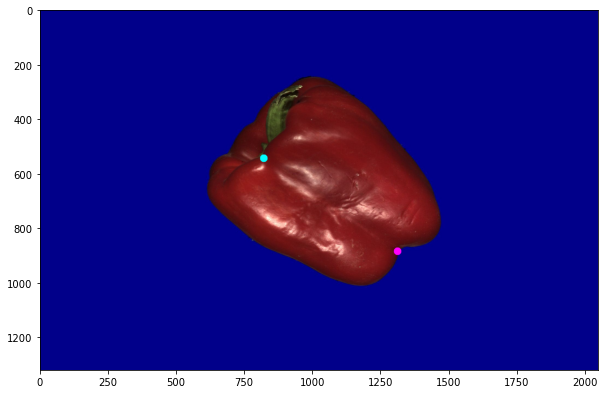

In [15]:
draw_points(dataset_dicts)

In [16]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x.yaml"))
cfg.DATASETS.TRAIN = ("pep_train",)
cfg.DATASETS.TEST = ("pep_valid",)
cfg.DATALOADER.NUM_WORKERS = 4
#cfg.MODEL.WEIGHTS="/media/asad/ADAS_CV/cuc/output_axels2/model_final.pth"
cfg.MODEL.WEIGHTS="/media/asad/ADAS_CV/vegs_results/models/pepper/scalecam_v1_v2-10-08/model_final.pth"
cfg["MODEL"]["ANCHOR_GENERATOR"]["ASPECT_RATIOS"][0]=[0.5,1.0,1.5]
cfg["INPUT"]["RANDOM_FLIP"]="horizontal"
cfg["INPUT"]["ROTATE"]=[-2.0,2.0]
cfg["INPUT"]["LIGHT_SCALE"]=2
cfg["INPUT"]["Brightness_SCALE"]=[0.5,1.5]
cfg["INPUT"]["Contrast_SCALE"]=[0.5,2]
cfg["INPUT"]["Saturation_SCALE"]=[0.5,2]
cfg["MODEL"]["KEYPOINT_ON"]=True
cfg.MODEL['ROI_KEYPOINT_HEAD']["NUM_KEYPOINTS"]=2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 1e-5  # pick a good LR
cfg.SOLVER.CHECKPOINT_PERIOD = 40
cfg.SOLVER.MAX_ITER = 200   #
cfg.SOLVER.STEPS=(2000, 3000)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES=1
cfg.MODEL.RETINANET.NUM_CLASSES=1
cfg.TEST.KEYPOINT_OKS_SIGMAS=[1,1]
cfg.TEST.EVAL_PERIOD=100
cfg.OUTPUT_DIR="/media/asad/ADAS_CV/vegs_results/models/pepper/keypoints-pipeline" 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print(f" The output directory is {cfg.OUTPUT_DIR}")

 The output directory is /media/asad/ADAS_CV/vegs_results/models/pepper/keypoints-pipeline


In [17]:
cfg.TEST.keys(),cfg.TEST

(dict_keys(['EXPECTED_RESULTS', 'EVAL_PERIOD', 'KEYPOINT_OKS_SIGMAS', 'DETECTIONS_PER_IMAGE', 'AUG', 'PRECISE_BN']),
 CfgNode({'EXPECTED_RESULTS': [], 'EVAL_PERIOD': 100, 'KEYPOINT_OKS_SIGMAS': [1, 1], 'DETECTIONS_PER_IMAGE': 100, 'AUG': CfgNode({'ENABLED': False, 'MIN_SIZES': (400, 500, 600, 700, 800, 900, 1000, 1100, 1200), 'MAX_SIZE': 4000, 'FLIP': True}), 'PRECISE_BN': CfgNode({'ENABLED': False, 'NUM_ITER': 200})}))

In [18]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
#from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.logger as logger
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
from detectron2.data import DatasetMapper, build_detection_test_loader
import torch

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        logger.logging.info(f"Mean Validation loss {mean_loss}")
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()
        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v) for k, v in metrics_dict.items()}
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        #self.trainer.storage.put_scalars(timetest=12)     

In [19]:
#import detectron2.utils.logger as logger
##dir(logger)
#dir(logger.logging)

In [20]:
from detectron2.evaluation import COCOEvaluator
class VegTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, output_dir=cfg.OUTPUT_DIR,kpt_oks_sigmas=cfg.TEST.KEYPOINT_OKS_SIGMAS)
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(self.cfg,self.cfg.DATASETS.TEST[0],DatasetMapper(self.cfg,True))))
        return hooks

In [21]:
trainer = VegTrainer(cfg) 
trainer.resume_or_load(resume=False )
trainer.train()

[09/28 13:58:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Processing json 0008.json
Processed images 0
Processing json 0009.json
Processed images 1
Processing json 0010.json
Processed images 2
Processing json 0011.json
Processed images 3
Processing json 0026.json
Processed images 4
Processing json 0038.json
Processed images 5
Processing json 0048.json
Processed images 6
[09/28 13:58:30 d2.data.build]: Removed 0 images with no usable annotations. 7 images left.
[09/28 13:58:30 d2.data.build]: Removed 0 images with fewer than 1 keypoints.
[09/28 13:58:30 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    pep     | 11           |
|            |              |
[09/28 13:58:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip(), RandomRotation(angle=[-2.0, 2.0]), RandomLighting(scale=2), RandomSaturation(intensity_min=0.5, inten

Some model parameters or buffers are not found in the checkpoint:
roi_heads.keypoint_head.conv_fcn1.{bias, weight}
roi_heads.keypoint_head.conv_fcn2.{bias, weight}
roi_heads.keypoint_head.conv_fcn3.{bias, weight}
roi_heads.keypoint_head.conv_fcn4.{bias, weight}
roi_heads.keypoint_head.conv_fcn5.{bias, weight}
roi_heads.keypoint_head.conv_fcn6.{bias, weight}
roi_heads.keypoint_head.conv_fcn7.{bias, weight}
roi_heads.keypoint_head.conv_fcn8.{bias, weight}
roi_heads.keypoint_head.score_lowres.{bias, weight}


[09/28 13:58:47 d2.engine.train_loop]: Starting training from iteration 0


/home/asad/anaconda/envs/detfastai/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448233824/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[09/28 13:59:13 d2.utils.events]:  eta: 0:03:31  iter: 19  total_loss: 8.153  loss_cls: 0.002756  loss_box_reg: 0.007319  loss_mask: 0.01736  loss_keypoint: 8.114  loss_rpn_cls: 0.0004398  loss_rpn_loc: 0.005541  time: 1.2056  data_time: 0.0342  lr: 1.9981e-07  max_mem: 7208M
[09/28 13:59:56 d2.utils.events]:  eta: 0:03:21  iter: 39  total_loss: 8.13  loss_cls: 0.004277  loss_box_reg: 0.009892  loss_mask: 0.0192  loss_keypoint: 8.086  loss_rpn_cls: 0.0005481  loss_rpn_loc: 0.00673  time: 1.2530  data_time: 0.0055  lr: 3.9961e-07  max_mem: 8618M
[09/28 14:00:47 d2.utils.events]:  eta: 0:02:44  iter: 59  total_loss: 8.148  loss_cls: 0.004046  loss_box_reg: 0.008394  loss_mask: 0.01747  loss_keypoint: 8.122  loss_rpn_cls: 0.00041  loss_rpn_loc: 0.005147  time: 1.2190  data_time: 0.0060  lr: 5.9941e-07  max_mem: 8782M
[09/28 14:01:25 d2.utils.events]:  eta: 0:02:20  iter: 79  total_loss: 8.138  loss_cls: 0.004158  loss_box_reg: 0.008292  loss_mask: 0.01828  loss_keypoint: 8.091  loss_rpn_c

/home/asad/anaconda/envs/detfastai/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448233824/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


[09/28 14:02:22 d2.evaluation.evaluator]: Total inference time: 0:00:00.351704 (0.175852 s / img per device, on 1 devices)
[09/28 14:02:22 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.139112 s / img per device, on 1 devices)
[09/28 14:02:22 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/28 14:02:22 d2.evaluation.coco_evaluation]: Saving results to /media/asad/ADAS_CV/vegs_results/models/pepper/keypoints-pipeline/coco_instances_results.json
[09/28 14:02:22 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.00 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50     

Processing json 0010.json
Processed images 2
Processing json 0011.json
Processed images 3
Processing json 0026.json
Processed images 4
Processing json 0038.json
Processed images 5
Processing json 0048.json
Processed images 6
[09/28 14:06:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/28 14:06:41 d2.data.common]: Serializing 7 elements to byte tensors and concatenating them all ...
[09/28 14:06:41 d2.data.common]: Serialized dataset takes 0.22 MiB
[09/28 14:06:41 d2.evaluation.evaluator]: Start inference on 7 images
[09/28 14:06:42 d2.evaluation.evaluator]: Total inference time: 0:00:00.355598 (0.177799 s / img per device, on 1 devices)
[09/28 14:06:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.139469 s / img per device, on 1 devices)
[09/28 14:06:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/28 14:06:42 d2

[09/28 14:07:11 d2.data.common]: Serializing 7 elements to byte tensors and concatenating them all ...
[09/28 14:07:11 d2.data.common]: Serialized dataset takes 0.22 MiB
[09/28 14:07:11 d2.evaluation.evaluator]: Start inference on 7 images
[09/28 14:07:13 d2.evaluation.evaluator]: Total inference time: 0:00:00.352829 (0.176414 s / img per device, on 1 devices)
[09/28 14:07:13 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.138714 s / img per device, on 1 devices)
[09/28 14:07:13 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/28 14:07:13 d2.evaluation.coco_evaluation]: Saving results to /media/asad/ADAS_CV/vegs_results/models/pepper/keypoints-pipeline/coco_instances_results.json
[09/28 14:07:13 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evalu

In [23]:
cfg["MODEL"]["ANCHOR_GENERATOR"]["SIZES"][0]

[32, 64, 128, 256, 512]

In [22]:
len(trainer.storage.histories()['validation_loss'].values())

2

In [23]:
len(trainer.storage.histories()['bbox/AP'].values())

3

In [26]:
boxap=[x for x,y  in trainer.storage.histories()['bbox/AP'].values()]

In [27]:
boxap

[100.0, 100.0, 100.0]

In [35]:
trainer.storage.histories()

defaultdict(fvcore.common.history_buffer.HistoryBuffer,
            {'rpn/num_pos_anchors': <fvcore.common.history_buffer.HistoryBuffer at 0x7f59997d9668>,
             'rpn/num_neg_anchors': <fvcore.common.history_buffer.HistoryBuffer at 0x7f59997d0240>,
             'roi_head/num_fg_samples': <fvcore.common.history_buffer.HistoryBuffer at 0x7f59997dfef0>,
             'roi_head/num_bg_samples': <fvcore.common.history_buffer.HistoryBuffer at 0x7f59997dfd68>,
             'fast_rcnn/cls_accuracy': <fvcore.common.history_buffer.HistoryBuffer at 0x7f59997df400>,
             'fast_rcnn/fg_cls_accuracy': <fvcore.common.history_buffer.HistoryBuffer at 0x7f59997df320>,
             'fast_rcnn/false_negative': <fvcore.common.history_buffer.HistoryBuffer at 0x7f59997df8d0>,
             'mask_rcnn/accuracy': <fvcore.common.history_buffer.HistoryBuffer at 0x7f599cd307f0>,
             'mask_rcnn/false_positive': <fvcore.common.history_buffer.HistoryBuffer at 0x7f59997dfa58>,
             'mask

In [22]:
trainer.storage.get_scalar('validation_loss')

AttributeError: 'EventStorage' object has no attribute 'get_scalar'

In [20]:
#from detectron2.evaluation import COCOEvaluator, inference_on_dataset
#from detectron2.data import build_detection_test_loader
#evaluator = COCOEvaluator("pep_valid",output_dir=cfg.OUTPUT_DIR,kpt_oks_sigmas=cfg.TEST.KEYPOINT_OKS_SIGMAS)
#val_loader = build_detection_test_loader(cfg, "pep_valid")
#res=inference_on_dataset(trainer.model, val_loader, evaluator)